In [ ]:
import zipfile
with zipfile.ZipFile('brain-tumor-classification-mri.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import os
print(os.listdir('/content'))

['.config', 'Training', 'brain-tumor-classification-mri.zip', 'Testing', 'kaggle.json', 'sample_data']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import io
from PIL import Image
from IPython.display import display, clear_output
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/effnet.keras
/content/brain-tumor-classification-mri.zip
/content/kaggle.json
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/config_sentinel
/content/.config/.last_update_check.json
/content/.config/.last_opt_in_prompt.yaml
/content/.config/default_configs.db
/content/.config/.last_survey_prompt.yaml
/content/.config/active_config
/content/.config/gce
/content/.config/logs/2024.11.25/19.12.20.690274.log
/content/.config/logs/2024.11.25/19.13.09.316504.log
/content/.config/logs/2024.11.25/19.12.55.136430.log
/content/.config/logs/2024.11.25/19.12.56.407212.log
/content/.config/logs/2024.11.25/19.12.42.183555.log
/content/.config/logs/2024.11.25/19.13.10.119162.log
/content/.config/configurations/config_default
/content/logs/validation/events.out.tfevents.1733243467.300b4f6367d0.1741.1.v2
/content/logs/train/events.out.tfevents.1733243330.300b4f6367d0.1741.0.v2
/content/Training/glioma_tumor/gg (760).jpg
/content/Training/glioma_

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 327.47it/s]


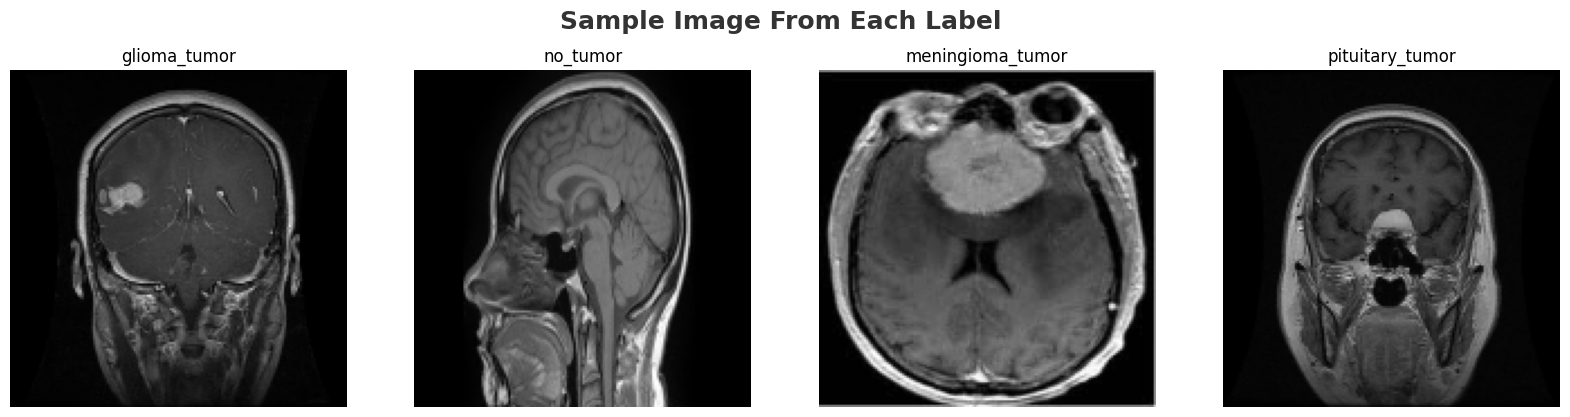

In [ ]:
c = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label', size=18, fontweight='bold', y=0.6, x=0.4, alpha=0.8)

for i in labels:
    # Select a random index for the current label
    indices = [index for index, label in enumerate(y_train) if label == i]
    random_index = random.choice(indices)

    ax[c].imshow(X_train[random_index])
    ax[c].set_title(y_train[random_index])
    ax[c].axis('off')
    c += 1

plt.show()

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 150, 150, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    verbose=1,
    batch_size=32,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stop]
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.7375 - loss: 0.6538
Epoch 1: val_accuracy improved from -inf to 0.74150, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 160s 936ms/step - accuracy: 0.7385 - loss: 0.6515 - val_accuracy: 0.7415 - val_loss: 0.9235 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9426 - loss: 0.1624
Epoch 2: val_accuracy did not improve from 0.74150
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9426 - loss: 0.1624 - val_accuracy: 0.7279 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9548 - loss: 0.1279
Epoch 3: val_accuracy did not improve from 0.74150

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9549 - loss: 0.1277 - val_accuracy: 0.4490 - val_loss: 3.1109 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accura

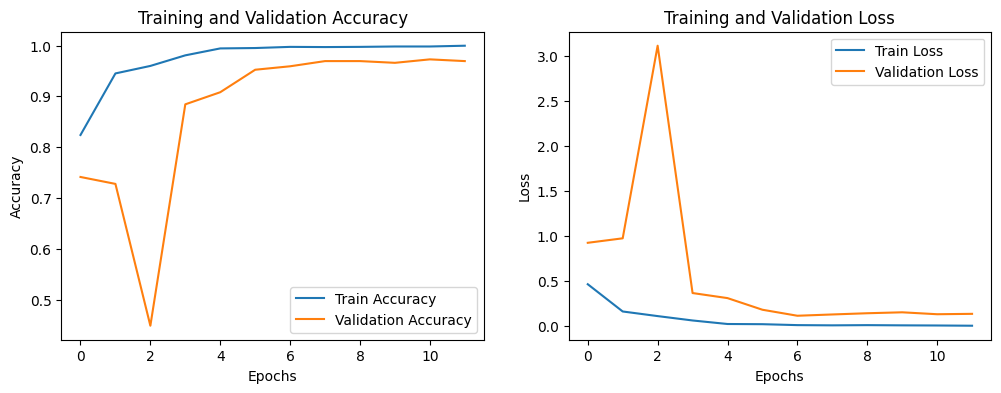

In [ ]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 741ms/step


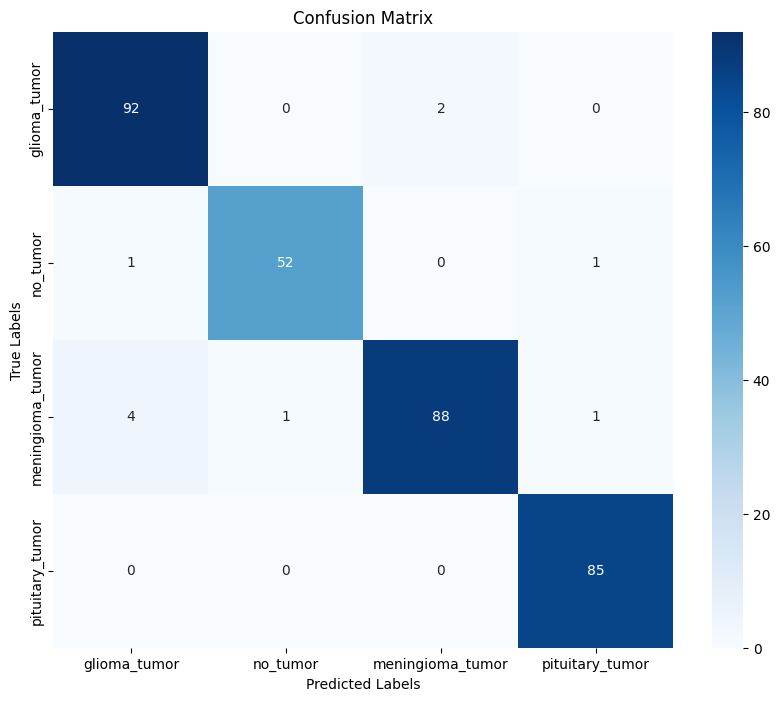

In [ ]:
# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=labels)
print('Classification Report:\n', class_report)

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.98      0.95      0.96        93
        no_tumor       0.98      0.98      0.98        51
meningioma_tumor       0.95      0.96      0.95        96
 pituitary_tumor       0.98      1.00      0.99        87

        accuracy                           0.97       327
       macro avg       0.97      0.97      0.97       327
    weighted avg       0.97      0.97      0.97       327



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

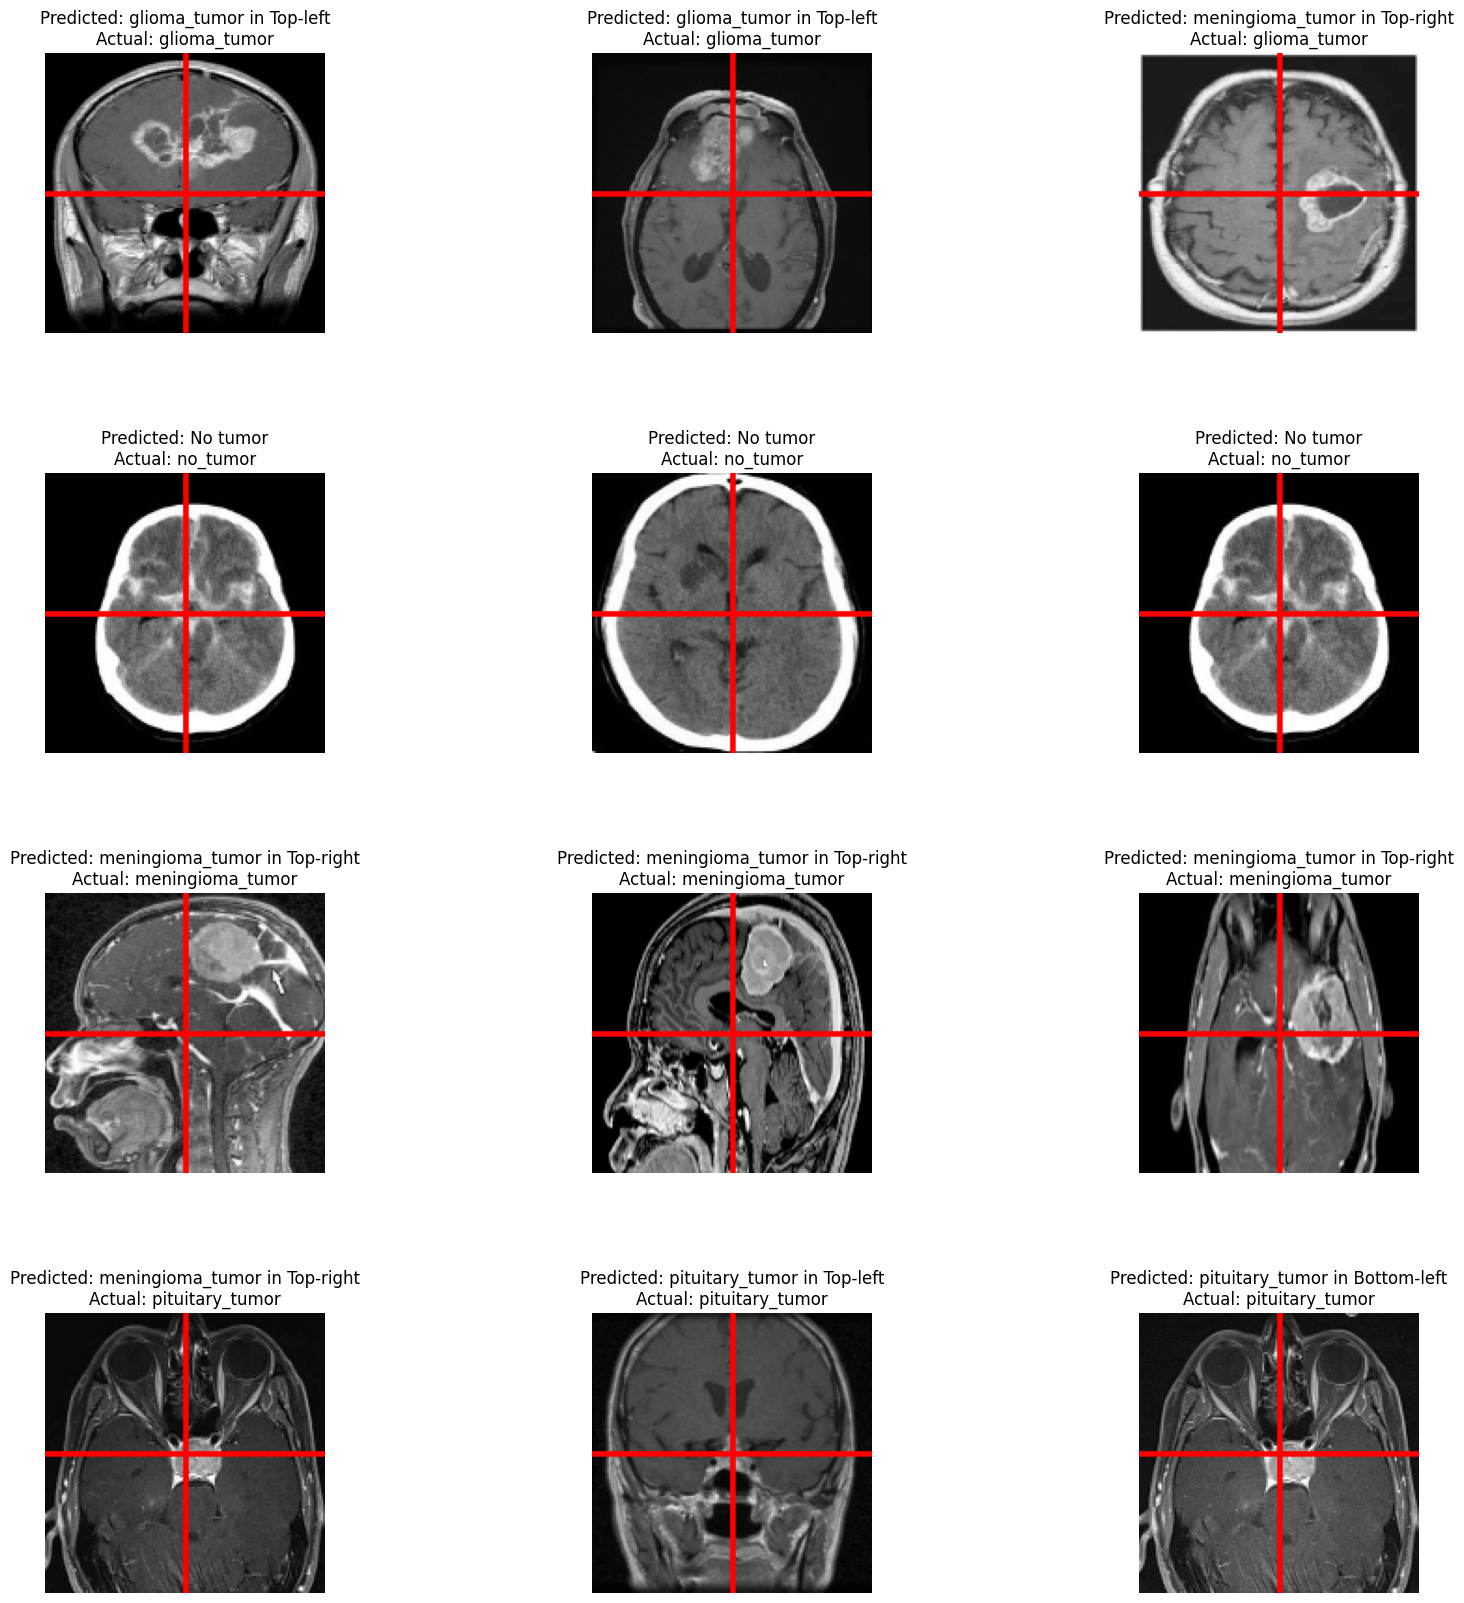

In [ ]:
# Function to divide an image into 4 regions and draw lines
def divide_image_with_lines(image):
    h, w, _ = image.shape
    regions = [
        ('Top-left', image[:h//2, :w//2]),  # Top-left
        ('Top-right', image[:h//2, w//2:]),  # Top-right
        ('Bottom-left', image[h//2:, :w//2]),  # Bottom-left
        ('Bottom-right', image[h//2:, w//2:])   # Bottom-right
    ]
    # Drawing lines to visualize the regions
    image_with_lines = image.copy()
    cv2.line(image_with_lines, (w//2, 0), (w//2, h), (255, 0, 0), 2)  # Vertical line
    cv2.line(image_with_lines, (0, h//2), (w, h//2), (255, 0, 0), 2)  # Horizontal line
    return image_with_lines, regions

# Function to resize regions to the expected input shape
def resize_region(region, target_size=(150, 150)):
    return cv2.resize(region, target_size)

# Loading some sample images from the testing directory
sample_images = []
sample_labels = []
for label in labels:
    folderPath = os.path.join('/content/Testing', label)
    images = random.sample(os.listdir(folderPath), 3)  # Take 3 random samples from each label
    for img_name in images:
        img_path = os.path.join(folderPath, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        sample_images.append(img)
        sample_labels.append(label)

# Converting to numpy array
sample_images = np.array(sample_images)

# Making predictions for each region
fig, ax = plt.subplots(4, 3, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
for i in range(len(sample_images)):
    image_with_lines, regions = divide_image_with_lines(sample_images[i])
    predictions = [model.predict(np.expand_dims(resize_region(region[1]), axis=0)) for region in regions]
    predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

    # Determining the region with the tumor
    tumor_region = "No tumor"
    for label, region in zip(predicted_labels, regions):
        if label != 'no_tumor':
            tumor_region = f"{label} in {region[0]}"
            break

    row = i // 3
    col = i % 3
    ax[row, col].imshow(image_with_lines)
    ax[row, col].set_title(f"Predicted: {tumor_region}\nActual: {sample_labels[i]}")
    ax[row, col].axis('off')
plt.show()